In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/mnist.csv')
data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(28 * 28)

784


We see here that, we have 60000 images of 28x28 pixels in grayscale. We will use these images to train our model. Each image has 785 dimensions, 784 pixels for the image and 1 label for the image. 

In [4]:
data = np.array(data)
print(data.shape)
# we shuffle the data
np.random.shuffle(data)

(60000, 785)


In [5]:
# In ML training, we split the data into training and testing data
# We use the training data to train the model, and then we use the testing data to evaluate the model
# the model CANNOT see the testing data during training
# 80% of the data is used for training, and 20% is used for testing
split_index = int(0.8 * data.shape[0])
training_data = data[:split_index]
testing_data = data[split_index:]
print(training_data.shape)
print(testing_data.shape)

(48000, 785)
(12000, 785)


Here we split the training set into X and Y, where X is the image and Y is the label. We will use X to train our model and Y to validate our model. Since out data has the first column as the label, we will split the first column as Y and the rest as X.

In [6]:
training_data_X = training_data[:, 1:]
training_data_Y = training_data[:, 0]
testing_data_X = testing_data[:, 1:]
testing_data_Y = testing_data[:, 0]

print(training_data_X.shape)
print(training_data_Y.shape)

print("Example X data: " + str(training_data_X[0]))
print("Example Y data: " + str(training_data_Y[0]))


(48000, 784)
(48000,)
Example X data: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   5 127 156 231 255 254 254 102   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  16 140 217 253 253 253 254
 253 253 247  87   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  96 

In [7]:
# defining the sigmoid function we discussed
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# defining the derivative of the sigmoid function, you can look up the proof for this
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

#converting the input Y labels to one hot encoding
def convert_to_one_hot(Y):
    num_data_points = Y.shape[0]
    num_classes = np.max(Y) + 1 # we can also hardcode this to be 10
    Y_one_hot = np.zeros((num_data_points, num_classes))
    Y_one_hot[np.arange(num_data_points), Y] = 1
    return Y_one_hot

# loss function, we want this to become less and less as we train the model
def loss_function(Y, Y_hat):
    return 0.5 * np.sum((Y - Y_hat) ** 2) / Y.shape[0]

def loss_function_derivative(Y, Y_hat):
    return (Y_hat - Y)  / Y.shape[0]


In [8]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size # 784 for this dataset, since each image is 28x28 = 784
        self.hidden_size = hidden_size # 16 from our discussion 
        self.output_size = output_size # 10 for this dataset, since we have 10 classes = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

        # we initialize the weights and biases randomly
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.b1 = np.zeros(self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b2 = np.zeros(self.output_size)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        
        return self.a2
    
    def backward(self, X, Y, learning_rate):
        # calculate the loss
        loss = loss_function(Y, self.a2)
        
        dL_da2 = loss_function_derivative(Y, self.a2) 
        da2_dz2 = sigmoid_derivative(self.z2)
        dL_dz2 = dL_da2 * da2_dz2
        dz2_dW2 = self.a1

        # calcuate the gradient of the loss with respect to w2 
        dL_dW2 = np.dot(dz2_dW2.T, dL_dz2) 
        # calculate the gradient of the loss with respect to b2
        dL_db2 = np.sum(dL_dz2, axis=0) 
        
        
        dz2_da1 = self.W2
        da1_dz1 = sigmoid_derivative(self.z1)
        dL_dz1 = np.dot(dL_dz2, dz2_da1.T) * da1_dz1
        dz1_dW1 = X

        # calculate the gradient of the loss with respect to w1
        dL_dW1 = np.dot(dz1_dW1.T, dL_dz1)
        # calculate the gradient of the loss with respect to b1
        dL_db1 = np.sum(dL_dz1, axis=0)
        
        # update the weights and biases
        self.W2 -= learning_rate * dL_dW2
        self.b2 -= learning_rate * dL_db2
        self.W1 -= learning_rate * dL_dW1
        self.b1 -= learning_rate * dL_db1
        
        return loss
    
    def get_batch(self, X, Y, batch_size = 32):
        num_data_points = X.shape[0]
        indices = np.random.choice(num_data_points, batch_size)
        return X[indices], Y[indices]
    
    def train(self, X, Y, epochs, learning_rate):
        num_batches = X.shape[0] // 128
        for i in range(epochs):
            for j in range(num_batches):
                X_batch, Y_batch = self.get_batch(X, Y)
                Y_hat = self.forward(X_batch)
                loss = self.backward(X_batch, Y_batch, learning_rate)
            print("Epoch: " + str(i) + " Loss: " + str(loss))
    
    def predict(self, X):
        return self.forward(X)
    
    def accuracy(self, X, Y):
        Y_hat = self.predict(X)
        Y_hat = np.argmax(Y_hat, axis=1)
        return np.mean(Y_hat == Y)

In [9]:
neuralnetwork = NeuralNetwork(784, 16, 10)

training_data_Y_one_hot = convert_to_one_hot(training_data_Y)

neuralnetwork.train(training_data_X, training_data_Y_one_hot, 100, 0.1)

print(neuralnetwork.accuracy(testing_data_X, testing_data_Y))

Epoch: 0 Loss: 0.5047825309009303
Epoch: 1 Loss: 0.4500255617500031
Epoch: 2 Loss: 0.41772520277569514
Epoch: 3 Loss: 0.4183381118919983
Epoch: 4 Loss: 0.417274581159526
Epoch: 5 Loss: 0.3898347531558927
Epoch: 6 Loss: 0.3849401420097928
Epoch: 7 Loss: 0.390463566893657
Epoch: 8 Loss: 0.3613280986484846
Epoch: 9 Loss: 0.3458375217810087
Epoch: 10 Loss: 0.30558190831709475
Epoch: 11 Loss: 0.32267366546241755
Epoch: 12 Loss: 0.364661121313295
Epoch: 13 Loss: 0.35573778518768995
Epoch: 14 Loss: 0.3047034787288481
Epoch: 15 Loss: 0.28003117938774613
Epoch: 16 Loss: 0.32963864661201575
Epoch: 17 Loss: 0.3488788374652703
Epoch: 18 Loss: 0.3154600166578092
Epoch: 19 Loss: 0.32064892558524727
Epoch: 20 Loss: 0.28420932261262766
Epoch: 21 Loss: 0.32800925794675206
Epoch: 22 Loss: 0.3267490879856827
Epoch: 23 Loss: 0.24515729681113185
Epoch: 24 Loss: 0.29469973553437523
Epoch: 25 Loss: 0.3108416488692288
Epoch: 26 Loss: 0.35454027263256266
Epoch: 27 Loss: 0.2785577566618613
Epoch: 28 Loss: 0.261

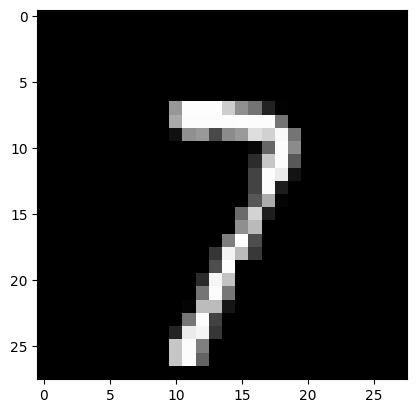

Predicted: 7


In [10]:
def plot_image(X):
    plt.imshow(X.reshape(28, 28), cmap='gray')
    plt.show()

data_point = 69
X = testing_data_X[data_point]
plot_image(X)

Y = testing_data_Y[data_point]
Y_hat = neuralnetwork.predict(X)

print("Predicted: " + str(np.argmax(Y_hat)))
